# Практическое задание по занятию Denosing Diffusional Models

ФИО: Бекетов Роман ML-21

## Задание

0) Скачайте репозиторий git clone https://github.com/awjuliani/pytorch-diffusion.git

1) Обучите модель для датасета Fasion MNIST. Продемонстрируйте обратный диффузионный процесс с нескольких random seeds (1 балл)

2) Добавьте к обучению DDPM условие на метку с помощью Classifier Free Guidance https://arxiv.org/abs/2207.12598. (2 балла)

3) Обучите модель в режиме inpainting. Параграф 4.1 в https://arxiv.org/pdf/2201.09865.pdf . (1 балл)


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install pytorch_lightning

In [3]:
!git clone https://github.com/awjuliani/pytorch-diffusion.git

Cloning into 'pytorch-diffusion'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 35 (delta 15), reused 29 (delta 10), pack-reused 0
Receiving objects: 100% (35/35), 1.48 MiB | 3.09 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [4]:
#!cp -r "/content/gdrive/My Drive/lightning_logs" "/content/lightning_logs"

In [5]:
import sys
sys.path.append('./pytorch-diffusion')

In [6]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset


import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

from PIL import Image
from torchvision.utils import make_grid
from __future__ import print_function
import argparse
import os
import pickle
import random

import torch.nn.parallel
import torch.backends.cudnn as cudnn


import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
# manualSeed = 1337
# manualSeed = random.randint(1, 10000) # use if you want new results
# random.seed(manualSeed)
# torch.manual_seed(manualSeed)

In [7]:
import torch
from data import DiffSet
import pytorch_lightning as pl
from model import DiffusionModel
from torch.utils.data import DataLoader
import imageio
import glob

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
# Training hyperparameters
diffusion_steps = 1000
dataset_choice = "Fashion"
max_epoch = 10
batch_size = 128

# Loading parameters
load_model = True # True
load_version_num = 0

In [9]:

# Code for optionally loading model
pass_version = None
last_checkpoint = None

if load_model:
    pass_version = load_version_num
    last_checkpoint = glob.glob(
        f"./lightning_logs/{dataset_choice}/version_{load_version_num}/checkpoints/*.ckpt"
    )[-1]

In [37]:
# Create datasets and data loaders
train_dataset = DiffSet(True, dataset_choice)
val_dataset = DiffSet(False, dataset_choice)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, shuffle=False)

# Create model and trainer
if load_model:
    model = DiffusionModel.load_from_checkpoint(last_checkpoint, in_size=train_dataset.size*train_dataset.size, t_range=diffusion_steps, img_depth=train_dataset.depth)
else:
    model = DiffusionModel(train_dataset.size*train_dataset.size, diffusion_steps, train_dataset.depth)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
print(pl.__version__)

2.1.2


In [ ]:
tb_logger = pl.loggers.TensorBoardLogger(
    "lightning_logs/",
    name=dataset_choice,
    version=pass_version,
)

trainer = pl.Trainer(
    max_epochs=max_epoch,
    log_every_n_steps=10,
    devices=1,
    accelerator="gpu",
    logger=tb_logger
)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# Train model
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name  | Type       | Params
--------------------------------------
0  | inc   | DoubleConv | 37.7 K
1  | down1 | Down       | 295 K 
2  | down2 | Down       | 1.2 M 
3  | down3 | Down       | 2.4 M 
4  | up1   | Up         | 6.2 M 
5  | up2   | Up         | 1.5 M 
6  | up3   | Up         | 406 K 
7  | outc  | OutConv    | 65    
8  | sa1   | SAWrapper  | 395 K 
9  | sa2   | SAWrapper  | 395 K 
10 | sa3   | SAWrapper  | 99.6 K
--------------------------------------
12.9 M    Trainable params
0         Non-trainable params
12.9 M    Total params
51.676    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [38]:
import random

In [39]:
def generate(count: int = 5):
  # Generate samples from denoising process
  gen_samples = []
  for _ in range(count):
    iter_sampels = []
    manualSeed = random.randint(1, 10000)
    random.seed(manualSeed)
    torch.manual_seed(manualSeed)

    x = torch.randn((1, train_dataset.depth, train_dataset.size, train_dataset.size))
    sample_steps = torch.arange(model.t_range-1, 0, -1)

    x = x.to(device)
    for t in sample_steps:
        x = model.denoise_sample(x, t.to(device))
        if t % 50 == 0:
            iter_sampels.append(x)

    gen_samples.append(iter_sampels)

  return gen_samples


In [40]:
def show_diffusion_process(gen_samples):
  for samples in gen_samples:
        plt.figure(figsize=(20, 3))
        for i, sample in enumerate(samples):
            plt.subplot(1, len(samples), i + 1)
            plt.imshow(sample.detach().numpy().reshape(32, 32), cmap=plt.cm.Greys_r)
            plt.axis('off')
        plt.show()

In [ ]:
gen_sampels = generate(7)

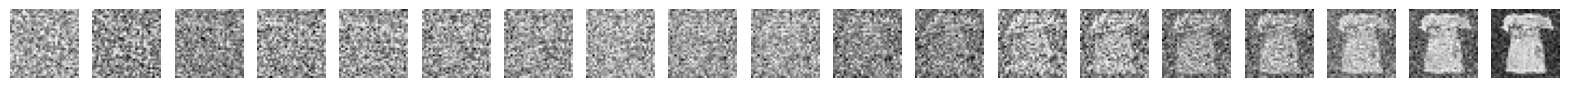

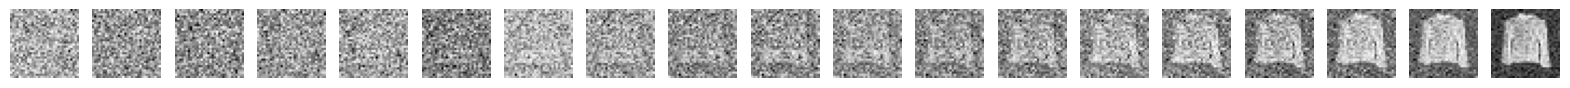

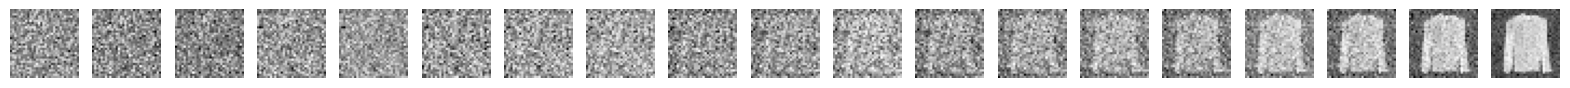

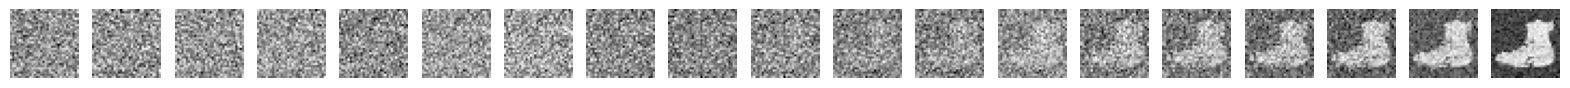

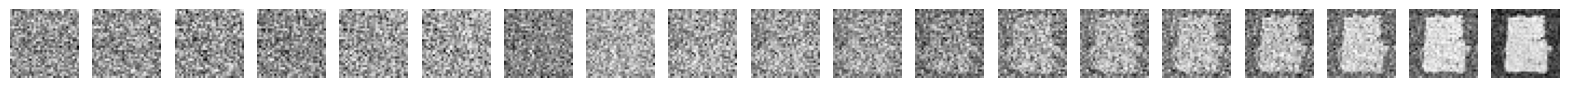

In [ ]:
show_diffusion_process(gen_sampels)

In [ ]:
#!cp -r "/content/lightning_logs" "/content/gdrive/My Drive/lightning_logs"

## DDPM условие на метку с помощью Classifier Free Guidance

In [42]:
import torch
from torch.utils.data import Dataset
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
from torchvision import transforms


class DiffSetCFG(Dataset):
    def __init__(self, train, p_uncond=0.5, dataset="MNIST"):
        transform = transforms.Compose([transforms.ToTensor()])

        datasets = {
            "MNIST": MNIST,
            "Fashion": FashionMNIST,
            "CIFAR": CIFAR10,
        }

        train_dataset = datasets[dataset](
            "./data", download=True, train=train, transform=transform
        )

        self.dataset_len = len(train_dataset.data)
        self.p_uncond = p_uncond

        if dataset == "MNIST" or dataset == "Fashion":
            pad = transforms.Pad(2)
            data = pad(train_dataset.data)
            data = data.unsqueeze(3)
            self.depth = 1
            self.size = 32
        elif dataset == "CIFAR":
            data = torch.Tensor(train_dataset.data)
            self.depth = 3
            self.size = 32
        self.input_seq = ((data / 255.0) * 2.0) - 1.0
        self.input_seq = self.input_seq.moveaxis(3, 1)
        self.labels = train_dataset.train_labels if train else train_dataset.test_labels

    def __len__(self):
        return self.dataset_len

    def __getitem__(self, item):
      p = np.random.uniform(0, 1)
      if p > self.p_uncond:
        return self.input_seq[item], self.labels[item]

      return self.input_seq[item], torch.tensor(-1)


In [43]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import math
from modules import *


class DiffusionModelCFG(pl.LightningModule):
    def __init__(self, in_size, t_range, img_depth, weight_sampling=3.0):
        super().__init__()
        self.beta_small = 1e-4
        self.beta_large = 0.02
        self.t_range = t_range
        self.in_size = in_size
        self.weight_sampling = weight_sampling

        bilinear = True
        self.inc = DoubleConv(img_depth+1, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        factor = 2 if bilinear else 1
        self.down3 = Down(256, 512 // factor)
        self.up1 = Up(512, 256 // factor, bilinear)
        self.up2 = Up(256, 128 // factor, bilinear)
        self.up3 = Up(128, 64, bilinear)
        self.outc = OutConv(64, img_depth)
        self.sa1 = SAWrapper(256, 8)
        self.sa2 = SAWrapper(256, 4)
        self.sa3 = SAWrapper(128, 8)

    def pos_encoding(self, t, channels, embed_size):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc.view(-1, channels, 1, 1).repeat(1, 1, embed_size, embed_size)

    def forward(self, x, label, t):
        """
        Model is U-Net with added positional encodings and self-attention layers.
        """
        label = label.unsqueeze(1).unsqueeze(2)
        label = label.expand(-1, -1, x.size(2), x.size(3))
        x = torch.cat([x, label], dim=1)

        x1 = self.inc(x)
        x2 = self.down1(x1) + self.pos_encoding(t, 128, 16)
        x3 = self.down2(x2) + self.pos_encoding(t, 256, 8)
        x3 = self.sa1(x3)
        x4 = self.down3(x3) + self.pos_encoding(t, 256, 4)
        x4 = self.sa2(x4)
        x = self.up1(x4, x3) + self.pos_encoding(t, 128, 8)
        x = self.sa3(x)
        x = self.up2(x, x2) + self.pos_encoding(t, 64, 16)
        x = self.up3(x, x1) + self.pos_encoding(t, 64, 32)
        output = self.outc(x)
        return output

    def beta(self, t):
        return self.beta_small + (t / self.t_range) * (
            self.beta_large - self.beta_small
        )

    def alpha(self, t):
        return 1 - self.beta(t)

    def alpha_bar(self, t):
        return math.prod([self.alpha(j) for j in range(t)])

    def get_loss(self, batch, batch_idx):
        """
        Algorithm 1 Joint training a diffusion model with classifier-free guidance
        """
        batch_img = batch[0]
        batch_label = batch[1]
        #lambda
        ts = torch.randint(0, self.t_range, [batch_img.shape[0]], device=self.device)
        noise_imgs = []
        # simple e
        epsilons = torch.randn(batch_img.shape, device=self.device)
        for i in range(len(ts)):

          sigma = math.sqrt(self.beta(ts[i]))
          alpha = self.alpha(ts[i])

          noise_imgs.append(
               alpha * batch_img[i] + sigma * epsilons[i]
          )
        noise_imgs = torch.stack(noise_imgs, dim=0)
        e_hat = self.forward(noise_imgs, batch_label, ts.unsqueeze(-1).type(torch.float))

        loss = nn.functional.mse_loss(
            e_hat.reshape(-1, self.in_size), epsilons.reshape(-1, self.in_size)
        )
        return loss

    def denoise_sample(self, z_t, label, t):
        """
        Algorithm 2 Conditional sampling with classifier-free guidance
        """
        with torch.no_grad():

          sigma = math.sqrt(self.beta(t))
          alpha = self.alpha(t)
          nullable_label = torch.full_like(torch.empty_like(label), -1, dtype=torch.long)

          epsilon_hat = self.forward(z_t, nullable_label, t)
          epsilon_hat_c = e_hat = self.forward(z_t, label, t)

          epsilon_hat_t = (1+self.weight_sampling)*epsilon_hat_c - self.weight_sampling*epsilon_hat
          x_hat_t = (z_t - sigma*epsilon_hat_t)/alpha
          return x_hat_t

    def training_step(self, batch, batch_idx):
        loss = self.get_loss(batch, batch_idx)
        self.log("train/loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.get_loss(batch, batch_idx)
        self.log("val/loss", loss)
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        return optimizer

In [44]:
# Training hyperparameters
diffusion_steps = 1000
dataset_choice = "Fashion"
max_epoch = 10
batch_size = 128

# Loading parameters
load_model = False # True
load_version_num = 0

# Code for optionally loading model
pass_version = None
last_checkpoint = None

if load_model:
    pass_version = load_version_num
    last_checkpoint = glob.glob(
        f"./lightning_logs/{dataset_choice}/version_{load_version_num}/checkpoints/*.ckpt"
    )[-1]

In [45]:
def custom_collate_fn(batch):
    images, labels = zip(*batch)

    images_tensor = torch.stack(images, dim=0)
    labels_tensor = torch.stack(labels, dim=0)

    return images_tensor, labels_tensor.unsqueeze(1)


# Create datasets and data loaders
train_dataset = DiffSetCFG(True, dataset=dataset_choice)
val_dataset = DiffSetCFG(False, dataset=dataset_choice)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=4,
    shuffle=True,
    collate_fn=custom_collate_fn,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=4,
    shuffle=False,
    collate_fn=custom_collate_fn,
)


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [46]:
# Create model and trainer
if load_model:
    model = DiffusionModelCFG.load_from_checkpoint(last_checkpoint, in_size=train_dataset.size*train_dataset.size, t_range=diffusion_steps, img_depth=train_dataset.depth)
else:
    model = DiffusionModelCFG(train_dataset.size*train_dataset.size, diffusion_steps, train_dataset.depth)

In [47]:
tb_logger = pl.loggers.TensorBoardLogger(
    "lightning_logs/",
    name=dataset_choice,
    version=pass_version,
)

trainer = pl.Trainer(
    max_epochs=max_epoch,
    log_every_n_steps=10,
    devices=1,
    accelerator="gpu",
    logger=tb_logger
)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [48]:
# Train model
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name  | Type       | Params
--------------------------------------
0  | inc   | DoubleConv | 38.3 K
1  | down1 | Down       | 295 K 
2  | down2 | Down       | 1.2 M 
3  | down3 | Down       | 2.4 M 
4  | up1   | Up         | 6.2 M 
5  | up2   | Up         | 1.5 M 
6  | up3   | Up         | 406 K 
7  | outc  | OutConv    | 65    
8  | sa1   | SAWrapper  | 395 K 
9  | sa2   | SAWrapper  | 395 K 
10 | sa3   | SAWrapper  | 99.6 K
--------------------------------------
12.9 M    Trainable params
0         Non-trainable params
12.9 M    Total params
51.678    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [49]:
labels_dict = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8 :"Bag",
    9: "Ankle boot",
}

In [67]:
def generateCFG(labels, count: int = 5):
  # Generate samples from denoising process
  gen_samples = []
  for i in range(count):
    iter_sampels = []
    manualSeed = random.randint(1, 10000)
    random.seed(manualSeed)
    torch.manual_seed(manualSeed)

    x = torch.randn((1, train_dataset.depth, train_dataset.size, train_dataset.size))
    sample_steps = torch.arange(model.t_range-1, 0, -1)
    label_i = labels[i].unsqueeze(0).unsqueeze(0)

    for t in sample_steps:
        x = model.denoise_sample(x, label_i, t)
        # TODO: sampling))))
        if t % 50 == 0:
            iter_sampels.append(x)

    iter_sampels.append(x)
    gen_samples.append(iter_sampels)

  return gen_samples


In [73]:
def show_diffusion_process_CFG(labels, gen_samples):
  for idx, samples in enumerate(gen_samples):
        plt.figure(figsize=(20, 3))
        for i, sample in enumerate(samples):
            plt.subplot(1, len(samples), i + 1)
            plt.imshow(sample.detach().numpy().reshape(32, 32), cmap=plt.cm.Greys_r)
            plt.axis('off')
        print(f"====== {labels_dict[labels[idx].item()]} ======")
        plt.show()

In [62]:
labels_for_test = torch.tensor([3,5,6,8,0], dtype=torch.long)

In [71]:
genCDG = generateCFG(labels_for_test, 5)

====== Dress ======


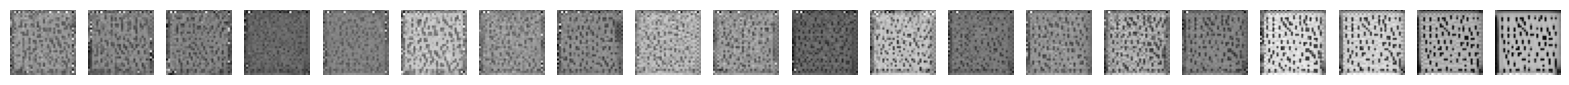

====== Sandal ======


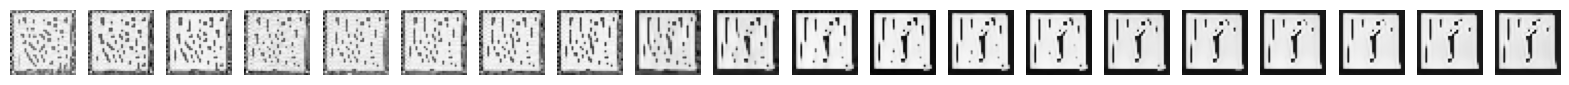

====== Shirt ======


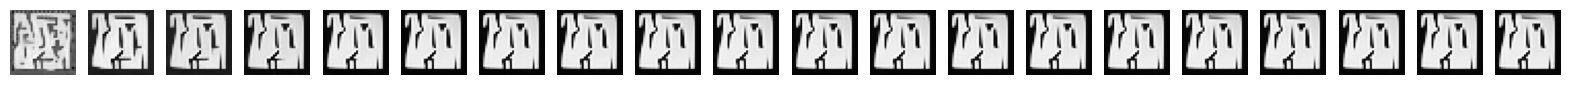

====== Bag ======


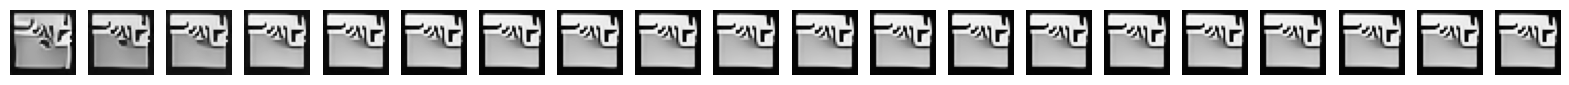

====== T-shirt/top ======


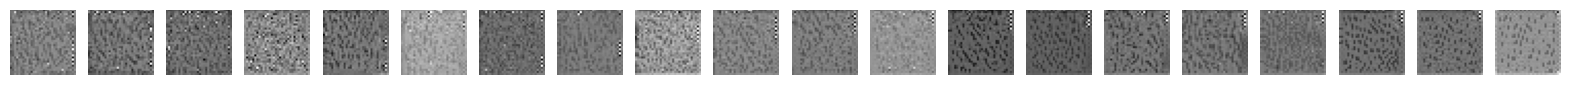

In [74]:
show_diffusion_process_CFG(labels_for_test, genCDG)